In [1]:
import os
import random
import shutil

datapath = 'data/cell_images/cell_images'
train_data = './train_data/train'
test_data = './train_data/test'

if not os.path.exists(train_data):
    os.makedirs(train_data)
if not os.path.exists(test_data):
    os.makedirs(test_data)

for fn in os.listdir(datapath):
    files = os.listdir(os.path.join(datapath, fn))
    i = int(len(files) * 0.15)
    
    random_files = random.sample(files, len(files))

    if not os.path.exists(os.path.join(train_data, fn)):
        os.mkdir(os.path.join(train_data, fn))
    if not os.path.exists(os.path.join(test_data, fn)):
        os.mkdir(os.path.join(test_data, fn))

    for j, fm in enumerate(random_files):
        if j < i:
            target_folder = (os.path.join(test_data, fn))
        else:
            target_folder = (os.path.join(train_data, fn))

        source_path = os.path.join(datapath, fn, fm)
        # print(target_folder)
        target_path = os.path.join(target_folder, fm)
        shutil.copy(source_path, target_path)

    print("Finish copying {} class!".format(fn))

Finish copying Parasitized class!
Finish copying Uninfected class!


In [2]:
import tensorflow as tf
import numpy as np


data_dir = './train_data/train'
num_classes = 2
batch_size = 64
target_size = (224, 224)


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,  
    validation_split=0.1, 
    # rotation_range=20,  
    # width_shift_range=0.1,  
    # height_shift_range=0.1, 
    # shear_range=0.2,  
    # zoom_range=0.2,  
    horizontal_flip=True  
)

train_dataset = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_dataset = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 24223 images belonging to 2 classes.
Found 2691 images belonging to 2 classes.


In [3]:

test_data_dir = './train_data/test' 
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,  
    # rotation_range=20,  
    # width_shift_range=0.1,  
    # height_shift_range=0.1,  
    # shear_range=0.2,  
    # zoom_range=0.2,  
    horizontal_flip=True  
)
test_dataset = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)


Found 7621 images belonging to 2 classes.


In [4]:

class AttentionBlock(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionBlock, self).__init__()
        self.conv = tf.keras.layers.Conv2D(64, (1, 1), activation='softmax')

    def call(self, inputs):
        attention_weights = self.conv(inputs)

        weighted_sum = attention_weights * inputs

        # output = tf.reduce_sum(weighted_sum, axis=[2, 3])
        return weighted_sum


class CNNWithAttention(tf.keras.Model):
    def __init__(self):
        super(CNNWithAttention, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.max_pool = tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=2)
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.attention = AttentionBlock()
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(64, activation='relu')
        self.fc2 = tf.keras.layers.Dense(2, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.max_pool(x)
        attention_weights = self.attention(x)
        # x = x * tf.expand_dims(attention_weights, axis=-1)
        x = tf.reduce_sum(attention_weights, axis=[1, 2])
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


class EnsembleCNN(tf.keras.Model):
    def __init__(self, num_networks=2):
        super(EnsembleCNN, self).__init__()
        self.num_networks = num_networks
        self.networks = [CNNWithAttention() for _ in range(num_networks)]

    def call(self, x):
        predictions = tf.zeros((tf.shape(x)[0], 2))
        for i in range(self.num_networks):
            predictions += self.networks[i](x)
        predictions /= self.num_networks
        return predictions


In [5]:

def custom_sparse_categorical_crossentropy(y_true, y_pred):

   
    loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)

    
    return tf.reduce_mean(loss)


In [6]:

class LossAccuracyHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.losses = []
        self.accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs['loss'])
        self.accuracies.append(logs['acc'])

In [7]:

model = EnsembleCNN(num_networks=2)
learning_rate = 0.0001
epochs = 10
optimizer = tf.keras.optimizers.Adam(learning_rate)

model.compile(optimizer = optimizer, loss = custom_sparse_categorical_crossentropy, metrics=['acc'])


checkpoint_path = 'best_model.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_best_only=True,
                                                         save_weights_only=True,
                                                         monitor='acc',
                                                         mode='max',
                                                         verbose=1)
history_callback = LossAccuracyHistory()

In [8]:

model.fit(train_dataset,
          epochs=epochs,
          validation_data=val_dataset,
          callbacks=[checkpoint_callback, history_callback])

Epoch 1/10
379/379 [==============================] - ETA: 0s - loss: 0.6785 - acc: 0.5009
Epoch 1: acc improved from -inf to 0.50089, saving model to best_model.h5
379/379 [==============================] - 861s 2s/step - loss: 0.6785 - acc: 0.5009 - val_loss: 0.6490 - val_acc: 0.5009
Epoch 2/10
379/379 [==============================] - ETA: 0s - loss: 0.6495 - acc: 0.5608
Epoch 2: acc improved from 0.50089 to 0.56083, saving model to best_model.h5
379/379 [==============================] - 857s 2s/step - loss: 0.6495 - acc: 0.5608 - val_loss: 0.6149 - val_acc: 0.6481
Epoch 3/10
379/379 [==============================] - ETA: 0s - loss: 0.5910 - acc: 0.6885
Epoch 3: acc improved from 0.56083 to 0.68852, saving model to best_model.h5
379/379 [==============================] - 864s 2s/step - loss: 0.5910 - acc: 0.6885 - val_loss: 0.6171 - val_acc: 0.6407
Epoch 4/10
379/379 [==============================] - ETA: 0s - loss: 0.5476 - acc: 0.7357
Epoch 4: acc improved from 0.68852 to 0.73

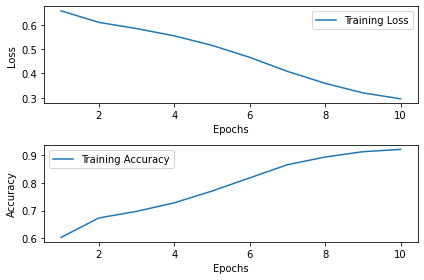

In [34]:

import matplotlib.pyplot as plt
losses = history_callback.losses
accuracies = history_callback.accuracies
epochs_range = range(1, len(losses) + 1)


plt.subplot(2, 1, 1)
plt.plot(epochs_range, losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs_range, accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("train.png")

plt.show()

2/2 [==============================] - 1s 189ms/step
ROC-AUC Score: 0.9230
Recall Score: 0.9043
Precision Score: 0.9393
F1 Score: 0.9215
Confusion Matrix:
[[1950  121]
 [ 198 1872]]


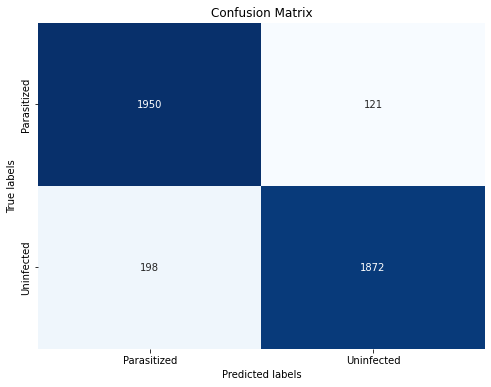

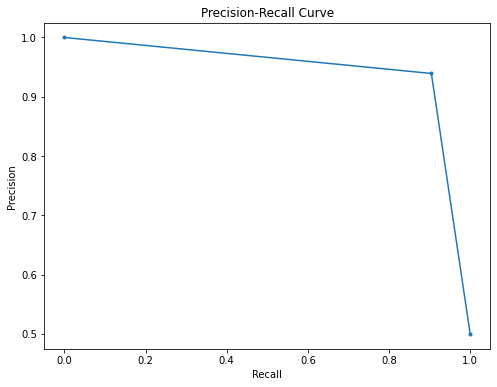

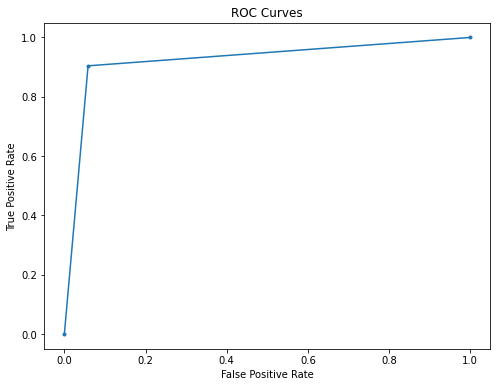

In [35]:

from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix, f1_score, precision_recall_curve,roc_curve

class_labels = ["Parasitized","Uninfected"]
y_pred_prob = []
batch_size = test_dataset.batch_size
num_samples = len(test_dataset.labels)  # 测试集样本数


for _ in range(int(np.ceil(num_samples / batch_size))):
    images, labels = next(test_dataset)
    predictions = model.predict(images)
    y_pred_prob.append(predictions)



y_pred_prob = tf.concat(y_pred_prob, axis=0)



y_pred_prob = tf.argmax(y_pred_prob, axis=1).numpy()
y_true = test_dataset.labels


roc_auc = roc_auc_score(y_true, y_pred_prob)
recall = recall_score(y_true, y_pred_prob)
precision = precision_score(y_true, y_pred_prob)
f1 = f1_score(y_true, y_pred_prob)

print(f'ROC-AUC Score: {roc_auc:.4f}')
print(f'Recall Score: {recall:.4f}')
print(f'Precision Score: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')


confusion_mat = confusion_matrix(y_true, y_pred_prob)
print('Confusion Matrix:')
print(confusion_mat)

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(confusion_mat, classes):
    """
    Plot the confusion matrix as a heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.savefig("Confusion_Matrix.png")
    plt.show()


plot_confusion_matrix(confusion_mat, classes=class_labels)



plt.figure(figsize=(8, 6))
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.savefig("Precision-Recall_Curve.png")
plt.show()


plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.plot(fpr, tpr, marker='.', label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.savefig("ROC_Curves.png")
plt.show()